In [3]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
from pylab import *
import seaborn as sns
sns.set_style("white")
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

sys.path.append('C:/Users/rohan/Dissertation/SyntacticSeachOnTimeSeries-master/SyntacticSeachOnTimeSeries-master')
sys.path.append('C:/Users/rohan/Dissertation/SyntacticSeachOnTimeSeries-master/SyntacticSeachOnTimeSeries-master/src')
sys.path.append('C:/Users/rohan/Dissertation/SyntacticSeachOnTimeSeries-master/SyntacticSeachOnTimeSeries-master/src/test_EcgBeatDetector')
sys.path.append('C:/Users/rohan/Dissertation/SyntacticSeachOnTimeSeries-master/SyntacticSeachOnTimeSeries-master/backend')
    
# import backend.gotstools as gt
# import src.test_EcgBeatDetector.wfdbtools as wfdb
import wfdbtools as wfdb
from scipy.io import loadmat

In [4]:
# import seaborn

In [5]:
# -*- coding: utf-8 -*-

import sys
import json
import regex as re
import numpy as np

from scipy import signal
from scipy.signal import filtfilt
from pylab import figure, plot, vlines

import datetime
import os

import sys

sys.path.append('C:/Users/rohan/Dissertation/transformer-master - Copy/transformer-master')
sys.path.append('C:/Users/rohan/Dissertation/transformer-master - Copy/transformer-master/src')

sys.path.append('C:/Users/rohan/Dissertation/SyntacticSeachOnTimeSeries-master/SyntacticSeachOnTimeSeries-master')
sys.path.append('C:/Users/rohan/Dissertation/SyntacticSeachOnTimeSeries-master/SyntacticSeachOnTimeSeries-master/backend')
sys.path.append('C:/Users/rohan/Dissertation/SyntacticSeachOnTimeSeries-master/SyntacticSeachOnTimeSeries-master/src')


with open('C:/Users/rohan/Dissertation/SyntacticSeachOnTimeSeries-master/SyntacticSeachOnTimeSeries-master/backend/gots_dictionary.json') as data_file:
    gots_func_dict = json.load(data_file)


# Filtering methods
def smooth(input_signal, window_len=10, window='hanning'):
    """
    @brief: Smooth the data using a window with requested size.
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal
    (with the window size) in both ends so that transient parts are minimized
    in the beginning and end part of the output signal.
    @param: input_signal: array-like
                the input signal
            window_len: int
                the dimension of the smoothing window. the default is 10.
            window: string.
                the type of window from 'flat', 'hanning', 'hamming',
                'bartlett', 'blackman'. flat window will produce a moving
                average smoothing. the default is 'hanning'.
    @return: signal_filt: array-like
                the smoothed signal.
    @example:
                time = linspace(-2,2,0.1)
                input_signal = sin(t)+randn(len(t))*0.1
                signal_filt = smooth(x)
    @see also:  numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman,
                numpy.convolve, scipy.signal.lfilter
    @todo: the window parameter could be the window itself if an array instead
    of a string
    @bug: if window_len is equal to the size of the signal the returning
    signal is smaller.
    """

    if input_signal.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if input_signal.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_len < 3:
        return input_signal

    if window not in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("""Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'""")

    sig = np.r_[2 * input_signal[0] - input_signal[window_len:0:-1],
                input_signal,
                2 * input_signal[-1] - input_signal[-2:-window_len-2:-1]]

    if window == 'flat':  # moving average
        win = np.ones(window_len, 'd')
    else:
        win = eval('np.' + window + '(window_len)')

    sig_conv = np.convolve(win / win.sum(), sig, mode='same')

    return sig_conv[window_len: -window_len]


def RemLowPass(input_signal, window_len):
    """
    @brief: for a given signal input_signal, it removes the low frequency fluctuations.
    @params:
    input_signal: signal
    window_len: window to the signal to be removed
    """
    a = input_signal - smooth(input_signal, window_len=window_len)
    return a


def lowpass(s, f, order=2, fs=1000.0, use_filtfilt=True):
    """
    @brief: for a given signal s rejects (attenuates) the frequencies higher
    then the cuttof frequency f and passes the frequencies lower than that
    value by applying a Butterworth digital filter
    @params:
    s: array-like
    signal
    f: int
    the cutoff frequency
    order: int
    Butterworth filter order
    fs: float
    sampling frequency
    @return:
    signal: array-like
    filtered signal
    """
    b, a = signal.butter(order, f / (fs/2))

    if use_filtfilt:
        return filtfilt(b, a, s)

    return signal.lfilter(b, a, s)


def highpass(s, f, order=2, fs=1000.0, use_filtfilt=True):
    """
    @brief: for a given signal s rejects (attenuates) the frequencies lower
    then the cuttof frequency f and passes the frequencies higher than that
    value by applying a Butterworth digital filter
    @params:
    s: array-like
    signal
    f: int
    the cutoff frequency
    order: int
    Butterworth filter order
    fs: float
    sampling frequency
    @return:
    signal: array-like
    filtered signal
    """

    b, a = signal.butter(order, f * 2 / (fs/2), btype='highpass')
    if use_filtfilt:
        return filtfilt(b, a, s)

    return signal.lfilter(b, a, s)


def bandpass(s, f1, f2, order=2, fs=1000.0, use_filtfilt=True):
    """
    @brief: for a given signal s passes the frequencies within a certain range
    (between f1 and f2) and rejects (attenuates) the frequencies outside that
    range by applying a Butterworth digital filter
    @params:
    s: array-like
    signal
    f1: int
    the lower cutoff frequency
    f2: int
    the upper cutoff frequency
    order: int
    Butterworth filter order
    fs: float
    sampling frequency
    @return:
    signal: array-like
    filtered signal
    """
    b, a = signal.butter(order, [f1 * 2 / fs, f2 * 2 / fs], btype='bandpass')

    if use_filtfilt:
        return filtfilt(b, a, s)

    return signal.lfilter(b, a, s)


# Statistical methods
def stat_white(x):
    return (x - np.mean(x)) / np.std(x)


def normalization(signal, newMin, newMax, xmin=None, xmax=None):
    if xmin is None:
        xmin = np.min(signal)

    if xmax is None:
        xmax = np.max(signal)

    return (signal - xmin) * (newMax - newMin) / (xmax - xmin) + newMin


# Connotation Methods

# 0. insert start and end
def StartOrEnd(fullsymbolicsequence, signs=['$',';']):
    result = fullsymbolicsequence
    result.insert(0,signs[0])
    result.insert(len(result),signs[1])
    return result

# 1. global mean comparison

def CompareGlobalMean(fullsequence, windowsize, signs=['a','b','c','d']):
    windowsize = round(windowsize)
    gmean = np.mean(fullsequence)
    iters = int(len(fullsequence) / windowsize)
    return_seq = fullsequence
    return_seq = return_seq.astype('str')
    if (len(fullsequence) % windowsize != 0):
        iters += 1
    subseqind = None
    print("iters:")
    print(iters)
    print(type(iters))
    i = 0
    while (i in range(0,len(fullsequence))):    
        if (i != iters):
            subseqind = range(i,i+windowsize)
            subsequence = fullsequence[subseqind]
        else: 
            subseqind = range(i,len(fullsequence))
            subsequence = fullsequence[subseqind]
        wmean = np.mean(subsequence)
        pctdiff = (wmean - gmean) / wmean * 100
        rep_symbol = None
        if pctdiff > 34.13:
            rep_symbol = signs[0]
        elif pctdiff < -34.13:
            rep_symbol = signs[3]
        elif ((pctdiff <= 34.13) and (pctdiff >= 0)):
            rep_symbol = signs[1]
        else:
            rep_symbol = signs[2]
        
        if (rep_symbol not in signs):
            print("rep_symbol :")
            print(rep_symbol)
            print("pctdiff:")
            print(pctdiff)
        return_seq[subseqind] = rep_symbol
        i += (windowsize)
        
    return return_seq

# 2. previous window mean comparison

def ComparePreviousMean(fullsequence, windowsize, signs=['e','f','g','h']):
    windowsize = round(windowsize)
    gmean = np.mean(fullsequence)
    iters = int(len(fullsequence) / windowsize)
    return_seq = fullsequence
    return_seq = return_seq.astype('str')
    if (len(fullsequence) % windowsize != 0):
        iters += 1
    subseqind = None
    print("iters:")
    print(iters)
    print(type(iters))
    i = 0
    pmean = 0
    while (i in range(0,len(fullsequence))):    
        if (i != iters):
            subseqind = range(i,i+windowsize)
            subsequence = fullsequence[subseqind]
        else: 
            subseqind = range(i,len(fullsequence))
            subsequence = fullsequence[subseqind]
        wmean = np.mean(subsequence)
        pctdiff = (wmean - pmean) / wmean * 100
        rep_symbol = None
        if pctdiff > 34.13:
            rep_symbol = signs[0]
        elif pctdiff < -34.13:
            rep_symbol = signs[3]
        elif ((pctdiff <= 34.13) and (pctdiff >= 0)):
            rep_symbol = signs[1]
        else:
            rep_symbol = signs[2]
        
        if (rep_symbol not in signs):
            print("rep_symbol :")
            print(rep_symbol)
            print("pctdiff:")
            print(pctdiff)
        return_seq[subseqind] = rep_symbol
        i += (windowsize)
        pmean = wmean
        
    return return_seq

# 3. 1st derivitive positive negative or equal

def FirstDerivativeSymbol(s, t, signs=['<', '-', '>']):
    # Quantization of the derivative.
    # TODO: Implement a better way of selecting chars
    print("Running FirstDerivativeSymbol")
    print("Input sequence:")
    print(s)
    ds1 = np.diff(s)
    print("Differentiated sequence:")
    print(ds1)
    print("parameter t:")
    print(t)
    x = np.empty(len(s), dtype=str)
    thr = (np.max(ds1)-np.min(ds1)) * t
    print("threshold thr:")
    print(thr)
    x[np.where(ds1 <= -thr)[0]] = signs[0]
    x[np.where(np.all([ds1 <= thr, ds1 >= -thr], axis=0))[0]] = signs[1]
    x[np.where(thr <= ds1)[0]] = signs[2]
    x[-1] = x[-2]
    return x

# 4. 2nd derivitive positive negative or equal

def SecondDerivativeSymbol(s, t, symbols=['{', '~', '}']):
    # Quantization of the derivative.
    # TODO: Implement a better threshold methodology.
    print("Running SecondDerivativeSymbol")
    print("Input sequence:")
    print(s)
    dds1 = np.diff(np.diff(s))
    print("Double Differentiated sequence:")
    print(dds1)
    print("parameter t:")
    print(t)
    x = np.empty(len(s), dtype=str)
    thr = (np.max(dds1) - np.min(dds1)) * t
    print("threshold thr:")
    print(thr)
    x[np.where(dds1 <= -thr)[0]] = symbols[0]
    x[np.where(np.all([dds1 <= thr, dds1 >= -thr], axis=0))[0]] = symbols[1]
    x[np.where(thr <= dds1)[0]] = symbols[2]
    x[-1] = x[-2]
    return x

# 5. insert global max and min

# 6. Seperator

def Separator(s, t, sign=','):
    x = np.empty(len(s), dtype=str)
    sep_str = ""
    for i in range(0,t):
        sep_str += ','
    x[:] = sep_str   
    return x


# def PeakOrLow(fullsequence, fullsymbolicsequence, signs=['p','l']):





def AmpC(s, t, p='>'):
    thr = ((np.max(s)-np.min(s)) * t) + np.min(s)
    if(p == '<'):
        s1 = (s <= (thr)) * 1
    elif(p == '>'):
        s1 = (s >= (thr)) * 1

    return s1


def DiffC(s, t, signs=['-', '_', '+']):
     # Quantization of the derivative.
    # TODO: Implement a better way of selecting chars
    ds1 = np.diff(s)
    x = np.empty(len(s), dtype=str)
    thr = (np.max(ds1)-np.min(ds1)) * t
    x[np.where(ds1 <= -thr)[0]] = signs[0]
    x[np.where(np.all([ds1 <= thr, ds1 >= -thr], axis=0))[0]] = signs[1]
    x[np.where(thr <= ds1)[0]] = signs[2]
    x[-1] = x[-2]

    return x


def Diff2C(s, t, symbols=['-', '_', '+']):
    # Quantization of the derivative.
    # TODO: Implement a better threshold methodology.
    dds1 = np.diff(np.diff(s))
    x = np.empty(len(s), dtype=str)
    thr = (np.max(dds1) - np.min(dds1)) * t
    x[np.where(dds1 <= -thr)[0]] = symbols[0]
    x[np.where(np.all([dds1 <= thr, dds1 >= -thr], axis=0))[0]] = symbols[1]
    x[np.where(thr <= dds1)[0]] = symbols[2]
    x[-1] = x[-2]

    return x


def RiseAmp(Signal, t):
    # detect all valleys
    val = detect_peaks(Signal, valley=True)
    # final pks array
    pks = []
    thr = ((np.max(Signal)-np.min(Signal)) * t)+np.mean(Signal)
    # array of amplitude of rising with size of signal
    risingH = np.zeros(len(Signal))
    Rise = np.array([])

    for i in range(0, len(val) - 1):
        # piece of signal between two successive valleys
        wind = Signal[val[i]:val[i + 1]]
        # find peak between two minimums
        pk = detect_peaks(wind, mph=0.1 * max(Signal))
        #print(pk)
        # if peak is found:
        if (len(pk) > 0):
            # append peak position
            pks.append(val[i] + pk)
            # calculate rising amplitude
            risingH[val[i]:val[i + 1]] = [wind[pk] - Signal[val[i]] for a in range(val[i], val[i + 1])]
            Rise = np.append(Rise, (wind[pk] - Signal[val[i]]) > thr)

    risingH = np.array(risingH > thr).astype(int)
    Rise = Rise.astype(int)
   
    return risingH


# Auxiliary methods
def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):
    """Detect peaks in data based on their amplitude and other features.

    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height.
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.

    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`

    The function can handle NaN's

    See this IPython Notebook [1]_.

    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb"""

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan - 1, indnan + 1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size - 1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind] - x[ind - 1], x[ind] - x[ind + 1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                              & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind


def _plot(x, mph, mpd, threshold, edge, valley, ax, ind):
    """Plot results of the detect_peaks function, see its help."""
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(8, 4))

        ax.plot(x, 'b', lw=1)
        if ind.size:
            label = 'valley' if valley else 'peak'
            label = label + 's' if ind.size > 1 else label
            ax.plot(ind, x[ind], '+', mfc=None, mec='r', mew=2, ms=8,
                    label='%d %s' % (ind.size, label))
            ax.legend(loc='best', framealpha=.5, numpoints=1)
        ax.set_xlim(-.02 * x.size, x.size * 1.02 - 1)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax.set_ylim(ymin - 0.1 * yrange, ymax + 0.1 * yrange)
        ax.set_xlabel('Data #', fontsize=14)
        ax.set_ylabel('Amplitude', fontsize=14)
        mode = 'Valley detection' if valley else 'Peak detection'
        ax.set_title("%s (mph=%s, mpd=%d, threshold=%s, edge='%s')"
                     % (mode, str(mph), mpd, str(threshold), edge))


def merge_chars(string_matrix):
    """
    Function performs the merge of the strings generated with each method. The function assumes
    that each string is organized in the StringMatrix argument as a column.
    The function returns the merged string.
    """
    col = np.size(string_matrix, axis=0)
    lines = np.size(string_matrix, axis=1)
    Str = ""
    for l in range(0, lines):
        for c in range(0, col):
            Str += str(string_matrix[c][l])

    return Str


def vmagnitude(v):
    """
    Returns the magnitude of a tridimensional vector signal.
    :param v: (ndarray-like)

    :return: The magnitude of the signal.
    """
    return np.sqrt(v[:, 0] ** 2 + v[:, 1] ** 2 + v[:, 2] ** 2)


def isfloat(value):
    try:
        float(value)
        return True
    except ValueError:
        return False


def prep_str(cfgstr, ls):
    """This function prepares the """
    if r' | ' in cfgstr:
        pstr = cfgstr.split(r' | ')
    else:
        pstr = [cfgstr] * ls
    return pstr


def plot_matches(s, m, scatter=False):
    figure(figsize=(16, 5));
    plot(s);
    if(scatter):
        [plot(i[0], s[i[0]], 'o', color='r') for i in m];
    else:
        [vlines(i[0], np.min(s), np.max(s), lw=3) for i in m];


# Main methods
def ssts(s, cfg, report='clean'):
    """
    Performs a query on a given time series based upon on a syntactic approach.
    :param s: array-like
        The input time series.
    :param cfg: dictionary
        A configuration dictionary structure that defines the query parameters.
    :param report: string
        A string containing the report type of returned values. Available types
        include: ``clean``, which returns the positive matches only and ``full``
        which returns the pre-processed signal, the connotation string and the
        positive matches.
    :return:
        ns: (array-like)
        The signal segment that corresponds to the query result.
    """
    # Handles exception to multisignal approach.
    print("Handling Multisignal")
    print("Input Sequence:")
    print(s)
    s = np.asarray(s)
    if s.ndim == 1:
        s = np.array([s])
    ns = np.copy(s)
    print("no of dimensions of s: ")
    print(s.ndim)

    # Layer 1: Pre-processing
    print("Layer 1: Preprocessing")
    pp_str = prep_str(cfg["pre_processing"], len(ns))
    operands = ""
    print("pp_str:")
    print(pp_str)
    print("len(ns):")
    print(len(ns))
    print("for loop for each element of sequence")
    for i in range(len(ns)):
        pp_func_stack = pp_str[i].split(" ")
        print("pp_func_stack")
        print(pp_func_stack)
        print("for loop for each element in pp_func_stack")
        for j, val in enumerate(pp_func_stack):
            if not isfloat(val):
                if val is "":
                    continue
                elif val not in list(gots_func_dict["pre_processing"].keys()):
                    sys.exit('Unknown pre-processing symbol.')
                else:
                    operator = val
                    for subval in pp_func_stack[j + 1:]:
                        if not isfloat(subval):
                            break
                        else:
                            operands += subval + ','

                    if operands is "":
                        ns[i] = eval(gots_func_dict["pre_processing"][operator] + '(ns[' + str(i) + '])')
                    else:
                        ns[i] = eval(gots_func_dict["pre_processing"][operator] + '(ns[' + str(i) + '],' + operands[:-1] + ')')
                    operands = ""
            else:
                continue

    # Layer 2: Symbolic Connotation
    sc_str = prep_str(cfg["connotation"], len(ns))
    operands = ""
    merged_sc_str = []
    print("Layer 2: Symbolic connotation")
    print("len(ns):")
    print(len(ns))
    print("for loop for each element in sequence")
    for i in range(len(ns)):
        sc_func_stack = sc_str[i].split(" ")
        print("sc_func_stack")
        print(sc_func_stack)
        print("for loop for every element in sc_func_stack")
        for j, val in enumerate(sc_func_stack):
            if not isfloat(val):
                if val is "":
                    sys.exit('At least a connotation method must be supplied.')
                elif val[0] == "[" and val[-1] == "]":
                    continue
                elif val not in list(gots_func_dict["connotation"].keys()):
                    print(gots_func_dict)
                    print(val)
                    sys.exit('Unknown connotation symbol.')
                else:
                    operator = val
                    print("operator: " + operator)
                    for subval in sc_func_stack[j + 1:]:
                        if not isfloat(subval) and subval[0] != "[" and subval[-1] != "]":
                            break
                        else:
                            operands += subval + ','

                    print("operands: " + operands)
                    if operands is "":
                        _constr = eval(gots_func_dict["connotation"][operator] + '(ns[' + str(i) + '])')

                    else:
                        _constr = eval(gots_func_dict["connotation"][operator] + '(ns[' + str(i) + '],' + operands[:-1] + ')')

                    operands = ""
                    print("_constr:")
                    print([_constr])
                    merged_sc_str += [_constr]
            else:
                continue
    constr = merge_chars(merged_sc_str)
    print("representation :")
    print(constr)

    # Layer 3: Search
    matches = []
    regit = re.finditer(cfg["expression"], constr)
    print("Expression")
    print(cfg["expression"])
    [matches.append((int(i.span()[0] / np.shape(merged_sc_str)[0]),
                     int(i.span()[1] / np.shape(merged_sc_str)[0]))) for i in regit]

    # removes unnecessary nesting in case ndim is 1.
    if ns.shape[0] == 1:
        ns = ns[0]

    if report is 'clean':
        print('REPORT CLEAN')
        print("Matches")
        print(matches)
        return matches, str(constr)
    elif report is 'full':
        print('REPORT FULL')
        return ns, constr, matches


# Introduction

## An initial overview of synthatic search on time series

The Synthatic Search on Time Series (SSTS) approach uses three steps that traduce a given time series into a set of primitives, in which the rules of regular expressions can be applied. This methodology presents several advantages over traditional methods and simplifies query problems on time series.

SSTS is divided into three modules: (1) Pre-processing, (2) Symbolic Connotation and (3) Search:

<img src="imgs/ssts_overview.png">

First, the user is able to perform pre-processing operations over time series using a pipeline of tokens that represents methods. Secondly, a set of connotation tokens is also used to customize the symbolic connotation. Finnaly, a search string is supplied in order to perform a query over the time series using the rules of regular expressions.

## SSTS main method

In order to perform a search, the user should call the SSTS main method: ```ssts(s, cfg)```. The ```s``` parameter represents the time series and should be a list or a ndarray. The ```cfg``` is a dictionary that contains a full description of the customization for each step.

The method returns an array of ```matches```, that correspond to the intervals at which positive matches were found using the search string.

# Examples
## 1. Start and end of plateau
* **Signal type**: Z-axis of accelerometer data;
* **Description**: The accelerometer sensor was positioned on the wrist. The data has been acquired with a sampling frequency of 1000 Hz, while the subject performed multiple levels of rotation of the wrist (45, 60 and 90 degrees). In each orientation, the subject has sustained the position for a 245 couple of seconds;
* **Problem**: Detect the beginning and ending of a plateau that corresponds to a rotation above 60 degrees.

In [6]:
s = np.loadtxt('C:/Users/rohan/Dissertation/SyntacticSeachOnTimeSeries-master/SyntacticSeachOnTimeSeries-master/examples/data/StartEndPlateau/plateau10.txt')[:, 4]
print(shape(s))

(37200,)


### 1.1. Search for the start of plateau

Handling Multisignal
Input Sequence:
[32775. 32767. 32769. ... 33384. 33379. 33370.]
no of dimensions of s: 
2
Layer 1: Preprocessing
pp_str:
['~ 500']
len(ns):
1
for loop for each element of sequence
pp_func_stack
['~', '500']
for loop for each element in pp_func_stack
Layer 2: Symbolic connotation
len(ns):
1
for loop for each element in sequence
sc_func_stack
['$', '5', '%', '5', '&', '0.05', '@', '0.05', '#', '1']
for loop for every element in sc_func_stack
operator: $
operands: 5,
iters:
7440
<class 'int'>
_constr:
[array(['c', 'c', 'c', ..., 'c', 'c', 'c'], dtype='<U32')]
operator: %
operands: 5,
iters:
7440
<class 'int'>
_constr:
[array(['e', 'e', 'e', ..., 'f', 'f', 'f'], dtype='<U32')]
operator: &
operands: 0.05,
Running FirstDerivativeSymbol
Input sequence:
[32774.94732057 32775.05267943 32775.15805154 ... 33368.98661893
 33369.39194763 33369.79731173]
Differentiated sequence:
[0.10535886 0.10537211 0.10540742 ... 0.40527225 0.4053287  0.4053641 ]
parameter t:
0.05
threshold t

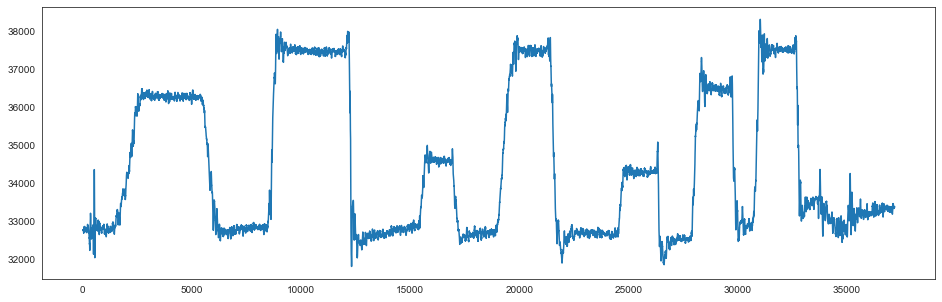

In [7]:
cfg = {
  "pre_processing": "~ 500",
  "connotation": "$ 5 % 5 & 0.05 @ 0.05 # 1",
  "expression": "\+[f|g]-"
}


# cfg = cfg.keys().replace("⇞", "â‡ž")
# cfg = cfg.keys().replace("†", "â€\xa0")
# cfg = cfg.keys().replace("⇵", "â‡µ")
# cfg = cfg.keys().replace("‡", "â€¡")
# cfg = cfg.keys().replace("↕", "â†•")

# matches = gt.ssts(s, cfg)
# print(matches)
# gt.plot_matches(s, matches)

matches, seq = ssts(s, cfg)
print(matches)
plot_matches(s, matches)
print("Output Seq")
print(seq)

In [22]:
cfg = {
  "pre_processing": "~ 500",
  "connotation": "â‡ž 0.82 â€\xa0 0.05",
  "expression": "\+1_"
}

matches, seq = ssts(s, cfg)
print(matches)
plot_matches(s, matches)
print(seq)

Handling Multisignal
Input Sequence:
[32775. 32767. 32769. ... 33384. 33379. 33370.]
no of dimensions of s: 
2
Layer 1: Preprocessing
pp_str:
['~ 500']
len(ns):
1
for loop for each element of sequence
pp_func_stack
['~', '500']
for loop for each element in pp_func_stack
Layer 2: Symbolic connotation
len(ns):
1
for loop for each element in sequence
sc_func_stack
['â‡ž', '0.82', 'â€\xa0', '0.05']
for loop for every element in sc_func_stack
operator: â‡ž
operands: 0.82,
_constr:
[array([0, 0, 0, ..., 0, 0, 0])]
operator: â€ 
operands: 0.05,
_constr:
[array(['_', '_', '_', ..., '_', '_', '_'], dtype='<U1')]
representation :
0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_

ValueError: too many values to unpack (expected 2)

In [87]:
# %tb

array([',', ',', ',', ..., ',', ',', ','], dtype='<U1')

In [59]:
import json
with open('C:/Users/rohan/Dissertation/SyntacticSeachOnTimeSeries-master/SyntacticSeachOnTimeSeries-master/backend/gots_dictionary.json') as data_file:
    gots_func_dict = json.load(data_file)
# print(gots_func_dict)
print(gots_func_dict["pre_processing"])
print(gots_func_dict["connotation"])
# print(gots_func_dict["expression"])


%tb

{'â˜±': 'highpass', 'â˜²': 'bandpass', 'â˜´': 'lowpass', '~': 'smooth', 'âˆ¥': 'abs', 'âŠš': 'stat_white'}
{'â‡ž': 'AmpC', 'â€\xa0': 'DiffC', 'â‡µ': 'ampDiffC', 'â€¡': 'Diff2C', 'â†•': 'RiseAmp'}


### 1.2. Search for the end of plateau

In [1]:
cfg = {
  "pre_processing": "~ 500",
  "connotation": "â‡ž 0.82 â€\xa0 0.05",
  "expression": "_1-"
}

matches = ssts(s, cfg)
plot_matches(s, matches)

NameError: name 'ssts' is not defined

## 2. Step detection
* **Signal type**: Magnitude of accelerometer data;
* **Description**: Data collected from a sensor located on the right pocket of a subject while performing sets of straight normal walk at 100 Hz;
* **Problem**: Detect the instants in time when a right or left heel floor contact is achieved during normal straight walk. This information can be used to create a step detector based on accelerometer data. Since the sensor is located on the right pocket, global minima will indicate the right heel contact and local minima will correspond to left heel contact.

In [5]:
vm = np.array(pd.read_csv('./data/StepDetection/test2/Accelerometer.txt', header=None))
t, m = vm[:, 0], vm[:, 1:-1]
s = gt.vmagnitude(m)[200:1400]

### 2.1. Left Heel

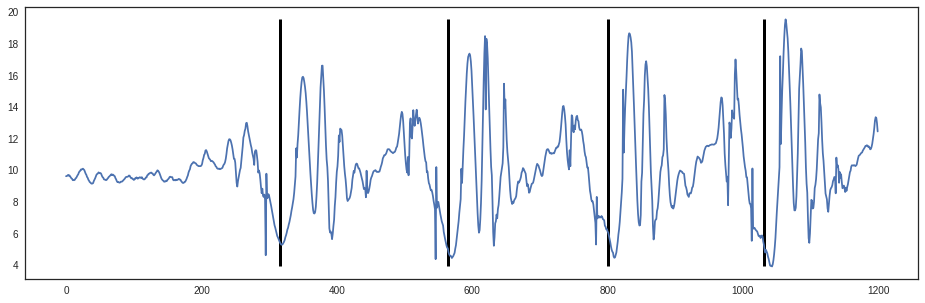

In [6]:
cfg = {
  "pre_processing": "☴ 2 2 100 ~ 50",
  "connotation": "⇞ 0.4 † 0.05",
  "expression": "0_0\+"
}

matches = gt.ssts(s, cfg)
gt.plot_matches(s, matches)

### 2.2. Right Heel

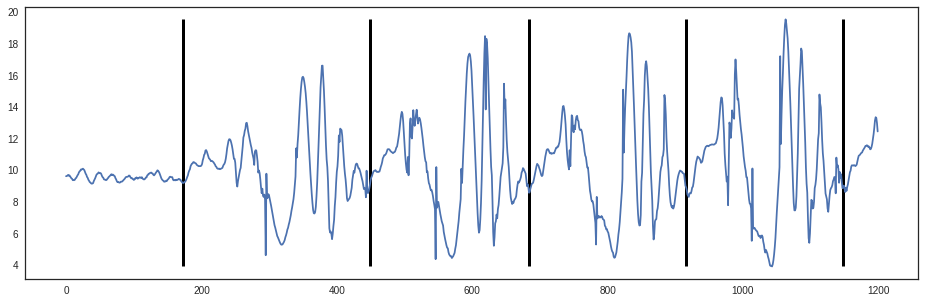

In [7]:
cfg = {
  "pre_processing": "☴ 2 2 100 ~ 50",
  "connotation": "⇞ 0.4 † 0.05",
  "expression": "1_1\+"
}

matches = gt.ssts(s, cfg)
gt.plot_matches(s, matches)

## 3. Systholic phase segmentation

* **Signal type**: Continuous ABP data;
* **Description**: This data was downloaded from the MIMIC-IIWaveform's Physiobank ATM database. It was collected from bedside patient monitors in adult and neonatal intensive care units (ICUs), 260 at 125 Hz. Multiple waveforms were acquired simultaneously, such as ECG, ABP and respiratory 
* **Problem**: The dicrotic notch corresponds to the physiological event of the aortical valve closure, which triggers the increase of the aortic pressure and signifies the end of the systolic phase. In this problem, it is asked to segment the systolic phase of the ABP wave.

In [8]:
s = loadmat('./data/BVP/3500015m_2.mat')['val'][0][205000:206000]

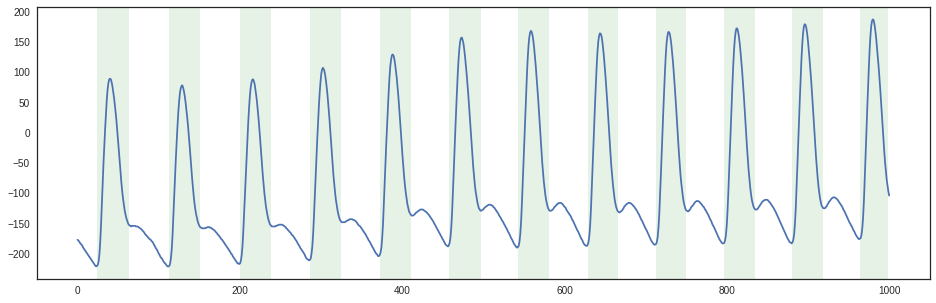

In [9]:
cfg = {
 "pre_processing": "☲ 1 20 2 125",
 "connotation": "↕ 0.6 † 0.01",
 "expression": "(1\+).+?0"
}

matches = gt.ssts(s, cfg)
figure(figsize=(16, 5)); plot(s); [axvspan(i[0], i[1], facecolor='green', alpha=0.10) for i in matches];

## 4. Electrocardiogram peak detector
* **Signal Type**: Electrocardiogram signal;
* **Description**: This data has been downloaded from the MIT-BIH Arrhythmia Database found at the Physiobank ATM. The source of the ECGs included in this database is a set of over 4000 long-term Holter recordings that were obtained by the Beth Israel Hospital Arrhythmia Laboratory between 1975 and 1979. The Database contains two main sets, one with 23 records chosen at random from this set, and the other with 25 records that include a variety of rare but clinically important phenomena. The recording were digitized at 360 samples per second per channel with 11-bit resolution over a 10 mV range.
* **Problem**: Detect all the major peaks from the record.

In [10]:
seq_data, seq_info = wfdb.rdsamp('./data/EcgBeatDetection/100', start=0, end=10)
t, s = seq_data[:, 1], seq_data[:, 2]

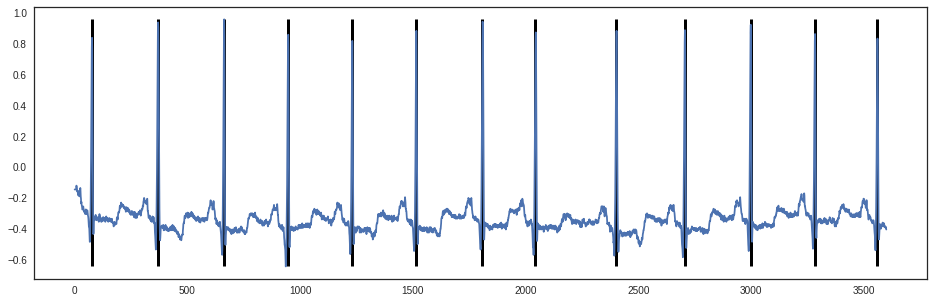

In [11]:
cfg = {
  "pre_processing": "☲ 5 50 2 360",
  "connotation": "† 0.01",
  "expression": "\+-"
}
matches = gt.ssts(s, cfg, report='clean')
gt.plot_matches(s, matches, scatter=True)

## 5. Straight line trajectory tracking
* **Signal type**: A vector of cartesian coordinates in two dimensional space;
* **Description**: This data was generated to simulate a spatial trajectory of a Human subject inside a building environment. Indoor navigation systems rely on a set of sensors that are able to convert contextual and physical information into the subject's absolute location inside a building;
* **Problem**: The automatic detection of features, such straight walks and turns can be used to look for trajectory anomalies.

In [12]:
mapxy = np.array(pd.read_csv('./data/TrajectoryTracking/coord_demo3.txt', header=None))
x, y = gt.smooth(mapxy[:, 0], 50), gt.smooth(mapxy[:, 1], 50)

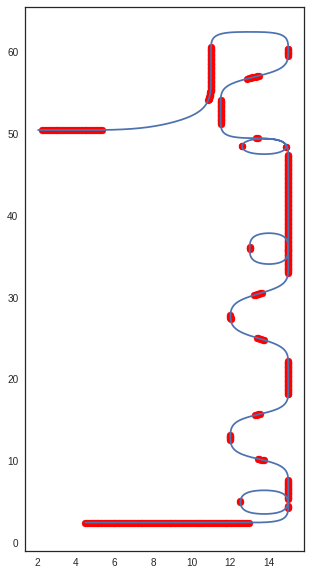

In [13]:
cfg = {
  "pre_processing": "",
  "connotation": "‡ 0.05",
  "expression": "_*?"
}
matches = gt.ssts([x, y], cfg, report='clean')

figure(figsize=(5, 10))
plot(x, y)
[scatter(x[arange(m[0], m[1])], y[arange(m[0], m[1])], color='r') for m in matches];

## 6. Stable Lifting Step Detection
* **Signal type**: Accelerometer data;
* **Description** : The accelerometer was positioned on the wrist while the subject performed a repetition of a weight lifting exercise (biceps curl) during 10 seconds. The data has been acquired at 1000 Hz.
* **Problem**: Since the first 5 seconds of the lifting exercise are unstable, the problem involves detecting the first stable lifting step, which occurs approximately 5 seconds after the beginning of the exercise.

In [14]:
acc = np.loadtxt('./data/StableLiftingStepDetection/test4.txt')[:10000,2:5]
acc[:,0] = (((acc[:,0]-28000)/(38000-28000))*2)-1
acc[:,1] = (((acc[:,1]-28000)/(38000-28000))*2)-1
acc[:,2] = (((acc[:,2]-28000)/(38000-28000))*2)-1
s = gt.vmagnitude(acc)

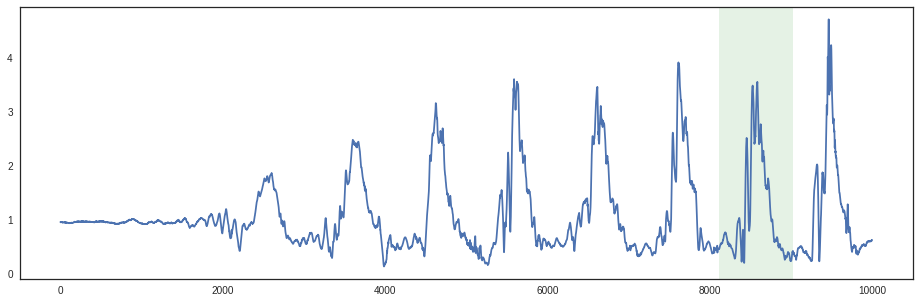

In [15]:
cfg = {
  "pre_processing": "⊚ ∥ ~ 1000 | ⊚ ~ 750",
  "connotation": "⇞ 0.1 | † 0.01 ['-','+','+']",
  "expression": "(?<=1.{10000,})(-.\+)(.+?)(-.\+)"
}

matches = gt.ssts(np.array([s, s]), cfg)
figure(figsize=(16, 5)); plot(s);axvspan(matches[0][0], matches[0][1], facecolor='green', alpha=0.10);